# Explore incipits
---
Look into the general architecture of the `incipit` -> `canonical story id` mapping. The goal is to do every kind of explicit, if/then analysis before moving into machine learning, answering questions like:
* What data has and has not been filled in yet?
* Has there been obvious errors in data entry?
* Are there exact matches for the unmapped rows?
* If we do use clustering, what's the general linguistic makeup of the incipits?

In [1]:
import pandas as pd
import numpy as np
import string
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('stripped_incipits.csv')
df.sample(5)

,canon_id,incipit,clean_incipit
334,NaN,ክፍል ፡ ሣልሳይ ፡ በእንተ ፡ ከሊፋ ።,ክፍል ሣልሳይ በእንተ ከሊፋ
540,292,ስምዑኬ፡ ኦሕዝበ፡ ክርስቲያን፡ ናየድንክሙ፡ ዘንተ፡ ተአምረ፡ ዓቢየ፡ ወመ...,ስምዑኬ ኦሕዝበ ክርስቲያን ናየድንክሙ ዘንተ ተአምረ ዓቢየ ወመድምመ ዘተገ...
5260,205,NaN,NaN
6962,309,NaN,NaN
4120,267,NaN,NaN


In [3]:
# What does this venn diagram look like? 
print(f'Total rows: {df.shape[0]}')
x = df[~pd.isna(df['incipit']) & ~pd.isna(df['canon_id'])].shape[0]
print(f'Both incipit and story: {x}')
x = df[pd.isna(df['incipit']) & ~pd.isna(df['canon_id'])].shape[0]
print(f'No incipit but story: {x}')
x = df[~pd.isna(df['incipit']) & pd.isna(df['canon_id'])].shape[0]
print(f'Incipit but no story: {x}')

Total rows: 8383
Both incipit and story: 1218
No incipit but story: 6815
Incipit but no story: 350


Number of words: 27374
Number of unique words: 7430
Number of unique words with count above 10: 368


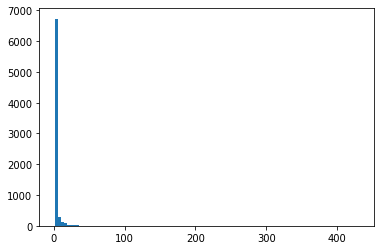

In [4]:
# What is the general linguistic structure?
unique_incipits = df['clean_incipit'].dropna().unique().tolist()

words = []
for w in unique_incipits:
    words.extend(w.split())
unique_words = set(words)
    
d = {}
for w in words:
    d[w] = d.get(w, 0) + 1
THRESHOLD = 10
unique_pop_words = [w for w, v in d.items() if v > THRESHOLD]

print(f"Number of words: {len(words)}")
print(f"Number of unique words: {len(set(words))}")
print(f"Number of unique words with count above {THRESHOLD}: {len(unique_pop_words)}")
plt.hist(d.values(), bins=100)
plt.show()

In [5]:
# Prepare mappings of incipit -> canon_id and clean_incipit -> canon_id
df_b = df[~pd.isna(df['incipit']) & ~pd.isna(df['canon_id'])]
df_unmapped = df[~pd.isna(df['incipit']) & pd.isna(df['canon_id'])]

raw_map = {}
for i, r in df_b.iterrows():
    raw_map[r['incipit']] = raw_map.get(r['incipit'], []) + [r['canon_id']]
for k, v in raw_map.items():
    raw_map[k] = set(raw_map[k])

clean_map = {}
for i, r in df_b.iterrows():
    clean_map[r['clean_incipit']] = clean_map.get(r['clean_incipit'], []) + [r['canon_id']]
for k, v in clean_map.items():
    clean_map[k] = set(clean_map[k])
# remove nan
del clean_map[np.nan]

In [6]:
# Does there exist inconsistent incipit -> story mappings?
#    Is the same incipit mapped to different stories?
for k, v in raw_map.items():
    if len(v) > 1:
        print(k, v)

catalog has incipits {'126', '131', '151', '164', '293', '255', '130', '179', '467', '186', '263', '183', '165', '254', '463'}


In [7]:
# Does there exist inconsistent cleaned_incipit -> story mappings?
#    Is the same incipit mapped to different stories?
any([len(canon_id) > 1 for clean_incipit, canon_id in clean_map.items()])

False

In [8]:
# Does there exist potential exact incipit -> story mappings?
#    Have we already labeled an incipit that exactly matches a different story?
any([incipit in raw_map for incipit in df_unmapped['incipit']])

False

In [9]:
# Does there exist cleaned incipit -> story mappings?
#    Once we strip away punctuation, is there an exact match between different stories?
any([incipit in clean_map for incipit in df_unmapped['clean_incipit'] if not pd.isna(incipit)])

False